# House Pricing Model

## Import Packages and set of data frame

In [172]:
%reset -f

In [173]:
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import numpy             as np
import csv
import xgboost           as xgb

from scipy.stats                            import t
from datetime                               import datetime
from statsmodels.tsa.stattools              import adfuller
from scipy                                  import stats
from statsmodels.tsa.stattools              import acf
from statsmodels.graphics.tsaplots          import plot_acf
from sklearn.preprocessing                  import StandardScaler
from sklearn.metrics                        import mean_squared_error, mean_absolute_error
from sklearn.model_selection                import GridSearchCV, TimeSeriesSplit, cross_val_score, cross_validate, train_test_split, KFold
from sklearn.neural_network                 import MLPRegressor
from sklearn.ensemble                       import RandomForestRegressor
from sklearn.linear_model                   import LinearRegression, Lasso, RidgeCV
from sklearn.metrics                        import r2_score
from sklearn.svm                            import SVR, LinearSVR
from sklearn                                import linear_model

In [174]:
df = pd.read_csv("train.csv")

In [175]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [176]:
#df.describe()

In [177]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [178]:
df['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40], dtype=int64)

# EDA and Feature Engineering

In [179]:
df = df[['LotArea','OverallQual', 'OverallCond','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold','SalePrice']]

In [180]:
# Impute missing values with column means for numerical columns
df = df.fillna(df.mean())

In [181]:
## drop na's
df = df.dropna()

In [182]:
# Check for any NaN or infinite values across rows
df[df.isin([np.nan, np.inf, -np.inf]).any(axis=1)].count().sum()

0

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   LotArea        1460 non-null   int64
 1   OverallQual    1460 non-null   int64
 2   OverallCond    1460 non-null   int64
 3   BsmtFinSF2     1460 non-null   int64
 4   BsmtUnfSF      1460 non-null   int64
 5   TotalBsmtSF    1460 non-null   int64
 6   1stFlrSF       1460 non-null   int64
 7   2ndFlrSF       1460 non-null   int64
 8   LowQualFinSF   1460 non-null   int64
 9   GrLivArea      1460 non-null   int64
 10  BsmtFullBath   1460 non-null   int64
 11  BsmtHalfBath   1460 non-null   int64
 12  FullBath       1460 non-null   int64
 13  HalfBath       1460 non-null   int64
 14  BedroomAbvGr   1460 non-null   int64
 15  KitchenAbvGr   1460 non-null   int64
 16  TotRmsAbvGrd   1460 non-null   int64
 17  Fireplaces     1460 non-null   int64
 18  GarageCars     1460 non-null   int64
 19  Garage

In [184]:
X = df[['LotArea','OverallQual', 'OverallCond','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold']]

In [185]:
y = df['SalePrice']

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Subsetting Data Into 3 Sections

### For a two-step stacked time-series model where the temporal order of the data need to be followed strictly, we split the data into three time-ordered batches.

### The first batch (called the base-training set) is for the Gridsearch hyper-parameter tuning of the base models.

### The optimized base models then make out-of-sample predictions on the next batch of data, which is used to train the meta model (let's call this the meta-training set).

### The fitted meta model then makes out-of-sample predictions on the final batch of data, which is used for scoring the models' performance (called the holdout test set).

In [187]:
# Extract the last 10% of observations as the holdout-test set
#df_holdout = df.iloc[-4380:]
#df_rest = df.iloc[:-4380]

In [188]:
#y_test = y_test.pop('SalePrice')

In [189]:
#y = df_rest.pop('Sale Price')

In [190]:
#X = df_rest

### The remaining training data is split into 2/3 base-training and 1/3 meta-training sets.

In [191]:
c = len(y)/3

In [192]:
# Data is organized in declining chronological order
y_meta = y_train[-int(c):]
y_base = y_train[:-int(c)]

In [193]:
X_meta = X_train[-int(c):]
X_base = X_train[:-int(c)]

## Train Models

In [194]:
scaler = StandardScaler()

In [195]:
X_base = scaler.fit_transform(X_base)
X_meta = scaler.transform(X_meta)
X_test = scaler.transform(X_test)

In [196]:
#Make an inner validation scheme for Gridsearch Cross-Validation
# adopt appropriate CV split
#time_split_inner = TimeSeriesSplit(n_splits = 3)

cv = KFold(n_splits=2, random_state=None, shuffle=False)

### Lasso Regression

In [197]:
lasso = Lasso(fit_intercept=1, alpha=0.05, max_iter=10000, random_state=0)

las_params = {'fit_intercept': [1, 0],
              'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1]}

In [198]:
gs_las = GridSearchCV(lasso, las_params, cv=cv, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_las.fit(X_base, y_base)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
             estimator=Lasso(alpha=0.05, fit_intercept=1, max_iter=10000,
                             random_state=0),
             n_jobs=-1,
             param_grid={'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1],
                         'fit_intercept': [1, 0]},
             scoring='neg_mean_squared_error', verbose=1)

### Two-Layer Neural Network

In [199]:
mlp = MLPRegressor(hidden_layer_sizes=(24,), alpha=1e-6, activation='relu', early_stopping=True, max_iter=20000, random_state=0)

mlp_params = {'hidden_layer_sizes': [(24,), (36,), (24,24), (24,12), (36,24), (36,12)], 
              'alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
              'activation': ['relu', 'identity', 'tanh']}

In [200]:
gs_mlp = GridSearchCV(mlp, mlp_params, cv=cv, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_mlp.fit(X_base, y_base)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
             estimator=MLPRegressor(alpha=1e-06, early_stopping=True,
                                    hidden_layer_sizes=(24,), max_iter=20000,
                                    random_state=0),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh'],
                         'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001],
                         'hidden_layer_sizes': [(24,), (36,), (24, 24),
                                                (24, 12), (36, 24), (36, 12)]},
             scoring='neg_mean_squared_error', verbose=1)

### Random Forest

In [201]:
rf = RandomForestRegressor(n_estimators=400, min_samples_split=3, max_features='sqrt', random_state=0)

rf_params = {'n_estimators': range(300, 500, 25),
             'min_samples_split': [2, 3, 4, 5, 6, 7],
             'max_features': ['log2', 'sqrt']}

In [202]:
gs_rf = GridSearchCV(rf, rf_params, cv=cv, scoring = 'neg_mean_squared_error', 
                     n_jobs=-1, verbose=1)

gs_rf.fit(X_base, y_base)

Fitting 2 folds for each of 96 candidates, totalling 192 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(max_features='sqrt',
                                             min_samples_split=3,
                                             n_estimators=400, random_state=0),
             n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'n_estimators': range(300, 500, 25)},
             scoring='neg_mean_squared_error', verbose=1)

### XGBoost

In [203]:
xgb = xgb.XGBRegressor(n_estimators=100, gamma=200, eta=0.1, subsample=1, objective='reg:squarederror', random_state=0)

xgb_params = {'n_estimators': range(70, 140, 10),
              'subsample': [0.5, 0.75, 1],
              'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
              'gamma': range(150, 160, 10)}

# gamma range changed from 150-310 to 150-160

In [204]:
gs_xgb = GridSearchCV(xgb, xgb_params, cv=cv, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)

gs_xgb.fit(X_base, y_base)

Fitting 2 folds for each of 126 candidates, totalling 252 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.1,
                                    eval_metric=None, gamma=200, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_c...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                 

### Linear Support Vector Regression

In [205]:
svr = LinearSVR(epsilon=10, C=35, fit_intercept=True, loss='squared_epsilon_insensitive', 
                max_iter=30000, random_state=8)

svr_params = {'epsilon': [8, 9, 10, 11, 12, 13, 14],
              'fit_intercept': [0, 1],
              'C': [33, 34, 35, 36, 37, 38, 39, 40, 41]}

In [206]:
gs_svr = GridSearchCV(svr, svr_params, cv=cv, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_svr.fit(X_base, y_base)

Fitting 2 folds for each of 126 candidates, totalling 252 fits


C:\Users\Micha\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
             estimator=LinearSVR(C=35, epsilon=10,
                                 loss='squared_epsilon_insensitive',
                                 max_iter=30000, random_state=8),
             n_jobs=-1,
             param_grid={'C': [33, 34, 35, 36, 37, 38, 39, 40, 41],
                         'epsilon': [8, 9, 10, 11, 12, 13, 14],
                         'fit_intercept': [0, 1]},
             scoring='neg_mean_squared_error', verbose=1)

### Support Vector Machine (Regression)

In [207]:
svm = SVR(kernel='rbf', gamma='auto', C=0.1, max_iter=30000)

svm_params = {'kernel': ['rbf', 'sigmoid', 'poly'],
              'gamma': ['scale', 'auto', 0.2], 
              'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]}

In [208]:
gs_svm = GridSearchCV(svm, svm_params, cv=cv, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_svm.fit(X_base, y_base)

Fitting 2 folds for each of 63 candidates, totalling 126 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
             estimator=SVR(C=0.1, gamma='auto', max_iter=30000), n_jobs=-1,
             param_grid={'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'gamma': ['scale', 'auto', 0.2],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

## Test Models

In [209]:
gs_las.best_params_
gs_mlp.best_params_
gs_rf.best_params_
gs_xgb.best_params_
gs_svr.best_params_
gs_svm.best_params_

{'C': 0.5, 'gamma': 0.2, 'kernel': 'poly'}

In [210]:
est_meta = pd.DataFrame(y_meta)
#y_meta = est_meta.pop('target')

In [211]:
est_meta['las_pred'] = gs_las.predict(X_meta)
est_meta['mlp_pred'] = gs_mlp.predict(X_meta)
est_meta['rf_pred'] = gs_rf.predict(X_meta)
est_meta['xgb_pred'] = gs_xgb.predict(X_meta)
est_meta['svr_pred'] = gs_svr.predict(X_meta)
est_meta['svm_pred'] = gs_svm.predict(X_meta)

In [212]:
est_meta = est_meta[['las_pred','mlp_pred','rf_pred','xgb_pred','svr_pred','svm_pred']]

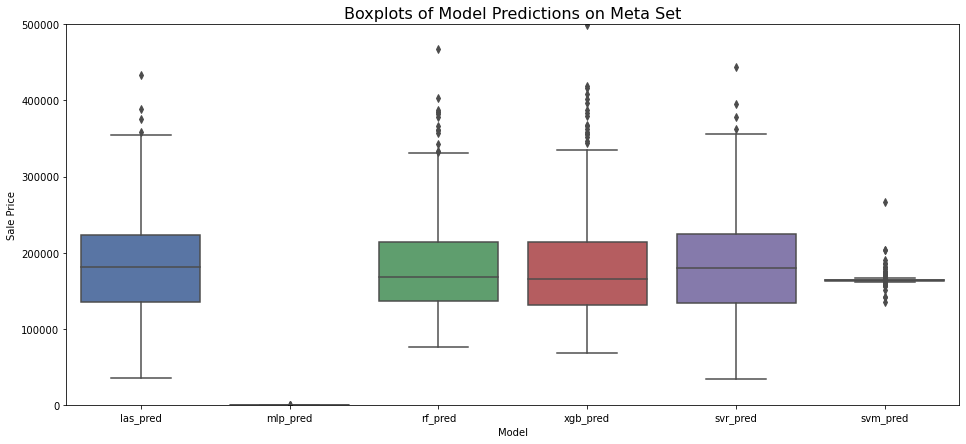

In [213]:
plt.figure(figsize=(16,7))

ax=sns.boxplot(data=est_meta, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(0, 500000))

plt.title('Boxplots of Model Predictions on Meta Set', fontsize=16)
plt.xlabel('Model')
plt.ylabel('Sale Price');

In [214]:
meta = LinearRegression()

In [215]:
meta.fit(est_meta, y_meta)

LinearRegression()

In [216]:
reg_dict = {
    'Lasso Regression': gs_las,
    'Multi-Layer Perceptron': gs_mlp, 
    'Random Forest': gs_rf,
    'XG Boost': gs_xgb,
    'Support Vector Regression' : gs_svr,
    'Support Vector Machine' : gs_svm
}

In [217]:
def reg_scoring(X, y, meta, reg_dict):
    '''
    Objective: Cycles through a dictionary of trained models, using them to make predictions, scores those 
    predictions on MAE, MSE & RMSE, and generates DataFrames of the scores and model predictions respectively
    
    X: DataFrame containing the explanatory variables
    
    y: Target variable
    
    meta: Trained meta model
    
    reg_dict: Dictionary of trained/fitted models
    '''
    
    test1_scores = []
    test2_scores = []
    
    df_pred = pd.DataFrame(columns=reg_dict.keys()) # Columns of DF will accord with reg_dict keys
    
    # Loop through Dictionary items
    for key, reg in reg_dict.items():
        
        pred_y = reg.predict(X)
        df_pred[key] = pd.Series(pred_y).transpose()
        
        # Computing test scores for each model
        test1_scores.append(round(mean_absolute_error(y, pred_y), 4))
        test2_scores.append(round(mean_squared_error(y, pred_y, squared=False), 4))
        
    # Generate results DataFrame
    results = pd.DataFrame({'Model': list(reg_dict.keys()), 
                            'Mean Absolute Error': test1_scores,
                            'Root Mean Squared Error': test2_scores
                            })

    # Generate Stack Model's predictions, and test scores
    df_pred['Stack Model'] = meta.predict(df_pred) # Adding 'Stack Model' to DataFrame of predictions
    
    s1 = round(mean_absolute_error(y, df_pred['Stack Model']), 4)
    s2 = round(mean_squared_error(y, df_pred['Stack Model'], squared=False), 4)
    
    
    # Add target variable to the DataFrame of predictions
    df_pred['Target'] = y.tolist()
        
        
    # Inserting the Stack scores to the results DataFrame
    row1 = ['Stack Model', s1, s2]
    results.loc[len(results)] = row1
    
    return results, df_pred

In [218]:
scores, df_pred = reg_scoring(X_test, y_test, meta, reg_dict)

In [219]:
scores

,Model,Mean Absolute Error,Root Mean Squared Error
0,Lasso Regression,24872.1146,36489.5078
1,Multi-Layer Perceptron,180368.2198,200141.3340
2,Random Forest,19278.7012,29400.9625
3,XG Boost,18495.0175,27983.2107
4,Support Vector Regression,24381.5943,35635.6723
5,Support Vector Machine,56774.9099,84916.7076
6,Stack Model,18032.9761,26555.8548


In [220]:
r2_score(df_pred[['Target']],df_pred[['Stack Model']]).round(3)

0.906

In [221]:
r2_score(df_pred[['Target']],df_pred[['Lasso Regression']]).round(3)

0.823

In [222]:
r2_score(df_pred[['Target']],df_pred[['Multi-Layer Perceptron']]).round(3)

-4.323

In [223]:
r2_score(df_pred[['Target']],df_pred[['XG Boost']]).round(3)

0.896

In [224]:
r2_score(df_pred[['Target']],df_pred[['Support Vector Regression']]).round(3)

0.831

In [225]:
r2_score(df_pred[['Target']],df_pred[['Support Vector Machine']]).round(3)

0.042

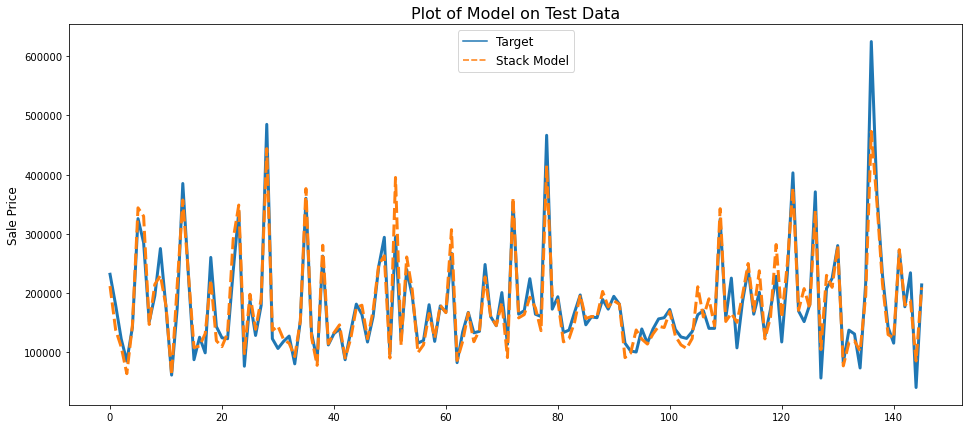

In [226]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Stack Model']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Plot of Model on Test Data', fontsize=16)
plt.xlabel('')
plt.ylabel('Sale Price', fontsize=12);

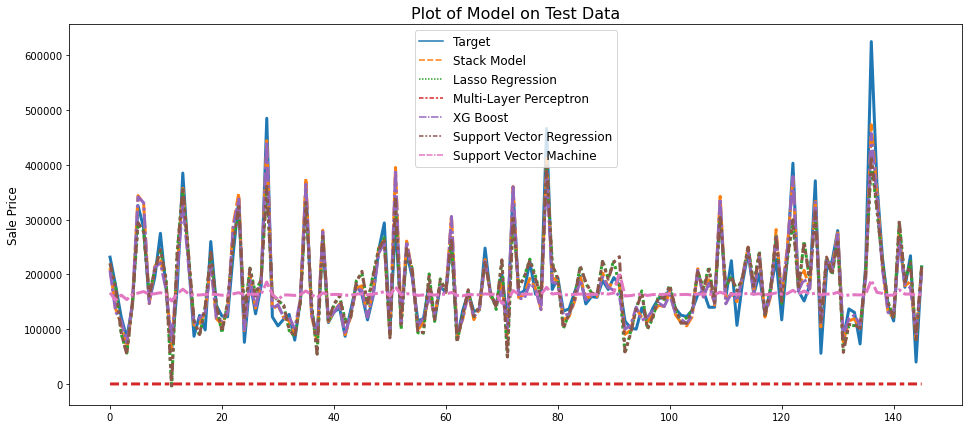

In [227]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Stack Model','Lasso Regression','Multi-Layer Perceptron',
                          'XG Boost','Support Vector Regression','Support Vector Machine']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Plot of Model on Test Data', fontsize=16)
plt.xlabel('')
plt.ylabel('Sale Price', fontsize=12);

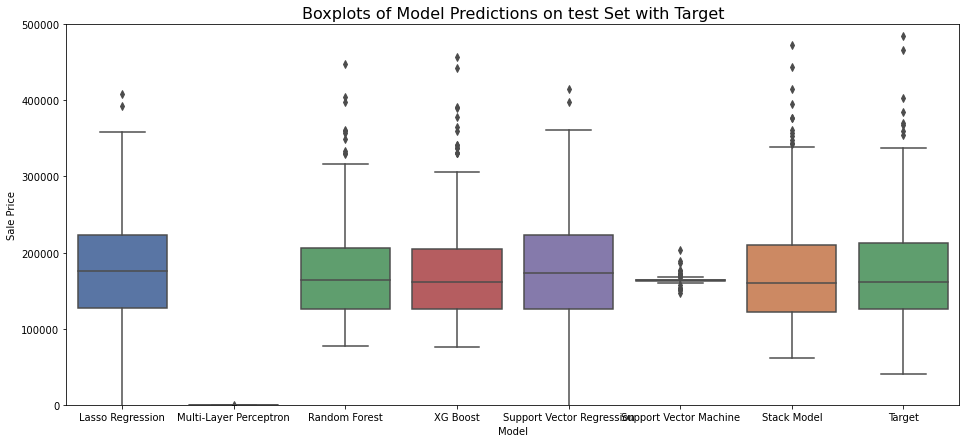

In [228]:
plt.figure(figsize=(16,7))

ax=sns.boxplot(data=df_pred, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(0, 500000))

plt.title('Boxplots of Model Predictions on test Set with Target', fontsize=16)
plt.xlabel('Model')
plt.ylabel('Sale Price');

## Predictions

In [229]:
### Input new data's figures into dataframe
new_test_df = pd.read_csv('test.csv')

In [230]:
new_test_x = new_test_df[['LotArea','OverallQual', 'OverallCond','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold']]

In [231]:
### Re-run this cell to make prediction


In [232]:
### run scores
